In [2]:
import os
import pandas as pd

# Directory where your CSV files are stored
directory = os.getcwd()

df_list=[]
# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check for CSV files
        
        # Split the filename and extract subject and activity
        parts = filename.split('_')
        subject = parts[0]  #'s1' is in the first part
        activity = parts[2]  # activity is in the third part (e.g., 'climbingdown')

        # Load the CSV file into a pandas DataFrame
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)

        # Add a new column 'Subjects' with the extracted subject
        df['Subjects'] = subject

        # Add a new column 'Activity' with the extracted activity
        df['Activity'] = activity

        # Append the DataFrame to the list
        df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
activity_monitoring_combined_df = pd.concat(df_list, ignore_index=True)
activity_monitoring_combined_df

,id,attr_time,attr_x,attr_y,attr_z,Subjects,Activity
0,1,1436371709030,-1.068412,9.526528,1.125873,s5,climbingup
1,2,1436371709031,-1.085172,9.570822,1.140837,s5,climbingup
2,3,1436371709032,-1.092953,9.595961,1.119289,s5,climbingup
3,4,1436371709033,-1.069011,9.576208,1.101333,s5,climbingup
4,5,1436371709034,-1.041478,9.518148,1.130662,s5,climbingup
...,...,...,...,...,...,...,...
1752354,33259,1436466248821,8.968679,0.821211,-3.290830,s6,running
1752355,33260,1436466248840,9.287108,0.810437,-3.722984,s6,running
1752356,33261,1436466248994,9.311649,0.729034,-3.933075,s6,running
1752357,33262,1436466248995,9.341577,0.757166,-3.727772,s6,running


#### Loading the required columns from orginal dataframe to features_df. It has total 5 columns: ['attr_x',  'attr_y', 'attr_z', 'Subjects', 'Activity']

In [3]:
 
features_df = activity_monitoring_combined_df[['attr_x', 'attr_y', 'attr_z','Subjects','Activity']]
print(features_df)


           attr_x    attr_y    attr_z Subjects    Activity
0       -1.068412  9.526528  1.125873       s5  climbingup
1       -1.085172  9.570822  1.140837       s5  climbingup
2       -1.092953  9.595961  1.119289       s5  climbingup
3       -1.069011  9.576208  1.101333       s5  climbingup
4       -1.041478  9.518148  1.130662       s5  climbingup
...           ...       ...       ...      ...         ...
1752354  8.968679  0.821211 -3.290830       s6     running
1752355  9.287108  0.810437 -3.722984       s6     running
1752356  9.311649  0.729034 -3.933075       s6     running
1752357  9.341577  0.757166 -3.727772       s6     running
1752358  9.392453  0.748787 -3.986346       s6     running

[1752359 rows x 5 columns]


I have used the available functions: def _hash(x) ,def s_entropy(freq_list),def ordinal_patterns(ts, embdim, embdelay),
def p_entropy(op), def complexity(op) provided in the lab to compute the permutaion entropy and complexity.

Permutation entropy: It measures the complexity of the time series by evaluating the ordinal patterns(permuataions) of data.
We can see in the code below that function def p_entropy(op) takes the ordinal pattern as an argument.

Embedding dimension: It specifies the number of points taken at a defined interval to form each "ordinal pattern" in the time series.

Embedding delay: It is the lag between the points in a pattern.

Signal length: It is the total number of data points or values in the time series.
It determines the overall size of the data segment used to calculate permutation entropy.

Code explaination:This code iterates over a dataset, computes permutation entropy and complexity metrics for each combination of subject, activity, accelerometer axis, signal length, embedding dimension, and delay, and stores these results
in a results_df. There are 6 nested for loops. 

->Step1: Initally, we ae looping through unique subjects from the features_df and filtering data for each subject.

->Step2: Then we are looping through unique activities for the unique subjects and filtering data subject wise.

->Step3: Now we are looping through accelometer_axis. For each activity,this loop is iterating over the list of axis:attr_x, attr_y, attr_z.

->Step4: Extracting the time series data. time_series = activity_data[col].dropna().values

->Step 5: We are looping throgh signal lengths.For each specified signal_length, it checks if the time series has enough data points.
If the time series is at least as long as length, it extracts a segment (signal) of the specified length.

->Step 6: Looping throgh the embedding dimension and delay.

->Step 7: Calculating ordinal patterns.

->Step 8: Calculating permutation entropy.

->Step 9: Calculating complexity.

->Step10: Storing the result in a dictionary.

In below code , complexity and permutation entropy is calculated as follows:

##### Complexity = Permutation_Entropy * Jensen_shanon_divergence
##### Permuataion_entropy = (s_entropy(p)/max_entropy)
##### where, max_entropy = np.log(len(ordinal_pat))
##### and s_entropy is shanon entropy





### Permutation Entropy Equation

$$[
PE = - \sum_{i=1}^{D!} \pi_i \log(\pi_i)
]$$

where, D is Embedding dimension
and $(pi_i)$ is permutation pattern. 

Later permutation entropy is normalized to have values between 0 and 1 using following formula:

### Normalized Permutation Entropy Equation

$$[
PE_{norm} = - \frac{1}{\log_2 D} \sum_{i=1}^{D!} \pi_i \log(\pi_i) \quad \quad PE_{norm} \in (0, 1)
]$$


### Complexity Equation

$$[
C_{js} = Q_0 J[P, P_e] H_s
]$$

where, $C_{js}$ is a Normalizing constant, $H_s$  is a Permutation Entropy, $J[P, P_e]$ is a Jensen-Shanon-Divergence
        

In [11]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd

embedding_dimensions = [3, 4, 5, 6]
delays = [1, 2, 3]
signal_lengths = [1024, 2048, 4096]
columns = ["attr_x", "attr_y", "attr_z"]

# Initialize an empty list to store the results
results = []

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)


def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)



for subject in features_df['Subjects'].unique():
    # Filter data for the current subject
    subject_data = features_df[features_df['Subjects'] == subject]
    
    # Loop through each activity for the current subject
    for activity in subject_data['Activity'].unique():
        activity_data = subject_data[subject_data['Activity'] == activity]
        #print("activity_data:",activity_data)
        for col in columns:
            time_series = activity_data[col].dropna().values  # Remove NaNs for each column
            #print('time_series:',time_series)
            # Loop through each signal length, embedding dimension, and delay
            for length in signal_lengths:
                if len(time_series) >= length:
                    signal = time_series[:length]
                    #print('singnal :',signal)
                    
                    for dimension in embedding_dimensions:
                        for delay in delays:
                            ordinal_pattern_counts = ordinal_patterns(signal, dimension,delay)
                            # Compute permutation entropy
                            perm_entropy = p_entropy(ordinal_pattern_counts)
                            
                            # Compute complexity
                            comp = complexity(ordinal_pattern_counts)
                            
                            # Store the result in a dictionary
                            result = {
                                'Subject': subject,
                                'Activity': activity,
                                'Accelerometer Axis': col,
                                'Signal Length': length,
                                'Dimension': dimension,
                                'Delay': delay,
                                'Permutation_Entropy': perm_entropy,
                                'Complexity': comp,
                                'Activity' :activity
                            }
                            
                            # Append the result to the results list
                            results.append(result)

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

print("Total rows in results_df:",len(results_df))
# Display results
results_df
                            
                            
             


Total rows in results_df: 6480


,Subject,Activity,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation_Entropy,Complexity
0,s5,climbingup,attr_x,1024,3,1,0.910388,0.077889
1,s5,climbingup,attr_x,1024,3,2,0.967399,0.029952
2,s5,climbingup,attr_x,1024,3,3,0.975406,0.022696
3,s5,climbingup,attr_x,1024,4,1,0.870686,0.134494
4,s5,climbingup,attr_x,1024,4,2,0.941821,0.068982
...,...,...,...,...,...,...,...,...
6475,s2,running,attr_z,4096,5,2,0.940417,0.099346
6476,s2,running,attr_z,4096,5,3,0.926888,0.114904
6477,s2,running,attr_z,4096,6,1,0.911658,0.168149
6478,s2,running,attr_z,4096,6,2,0.923292,0.152693


### 
select one particular subject of your choice (e.g 3), a particular attribute of your choice (e.g x) and a particular Signal length (e.g 1024) and filter the data for these specifics

##### Filtering data for subject= s5 , signal_length=1024, attribute=attr_x from results_df

In [12]:
# selecting subject s5 , signal length =1024 , attribute =attr_x

s5_filtered_data = results_df[
    (results_df['Subject']=='s5') & 
    (results_df['Accelerometer Axis']=='attr_x') & 
    (results_df['Signal Length'] == 1024)
]

print("Total rows in filtered data for subject s5:",len(s5_filtered_data))
s5_filtered_data

Total rows in filtered data for subject s5: 48


,Subject,Activity,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation_Entropy,Complexity
0,s5,climbingup,attr_x,1024,3,1,0.910388,0.077889
1,s5,climbingup,attr_x,1024,3,2,0.967399,0.029952
2,s5,climbingup,attr_x,1024,3,3,0.975406,0.022696
3,s5,climbingup,attr_x,1024,4,1,0.870686,0.134494
4,s5,climbingup,attr_x,1024,4,2,0.941821,0.068982
5,s5,climbingup,attr_x,1024,4,3,0.957699,0.051624
6,s5,climbingup,attr_x,1024,5,1,0.849132,0.191200
7,s5,climbingup,attr_x,1024,5,2,0.920750,0.122935
8,s5,climbingup,attr_x,1024,5,3,0.942968,0.090879
9,s5,climbingup,attr_x,1024,6,1,0.885896,0.167449


### 

Using scatter plots, identify the optimum dimension and delay that provide the best separation between walking and running for the filtered data from task 3.

##### Filtering data for activities: walking and runnig for subject "s5" from s5_filtered_data and storing result in "activity_data_walk_run".

In [13]:
## Filter data for activities : walking and running 

activity_data_walk_run = s5_filtered_data[s5_filtered_data['Activity'].isin(['walking', 'running'])]

print("Total rows for running and walking activity for Subject 5 is :",len(activity_data_walk_run))

print(activity_data_walk_run.columns)

activity_data_walk_run



Total rows for running and walking activity for Subject 5 is : 24
Index(['Subject', 'Activity', 'Accelerometer Axis', 'Signal Length',
       'Dimension', 'Delay', 'Permutation_Entropy', 'Complexity'],
      dtype='object')


,Subject,Activity,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation_Entropy,Complexity
108,s5,walking,attr_x,1024,3,1,0.911171,0.077933
109,s5,walking,attr_x,1024,3,2,0.959921,0.037229
110,s5,walking,attr_x,1024,3,3,0.975209,0.023244
111,s5,walking,attr_x,1024,4,1,0.860618,0.149080
112,s5,walking,attr_x,1024,4,2,0.930789,0.081356
113,s5,walking,attr_x,1024,4,3,0.955368,0.054971
114,s5,walking,attr_x,1024,5,1,0.842642,0.204974
115,s5,walking,attr_x,1024,5,2,0.908434,0.139263
116,s5,walking,attr_x,1024,5,3,0.938289,0.100734
117,s5,walking,attr_x,1024,6,1,0.890571,0.166240


#### Scatter plot for walking and running activities of subject s5

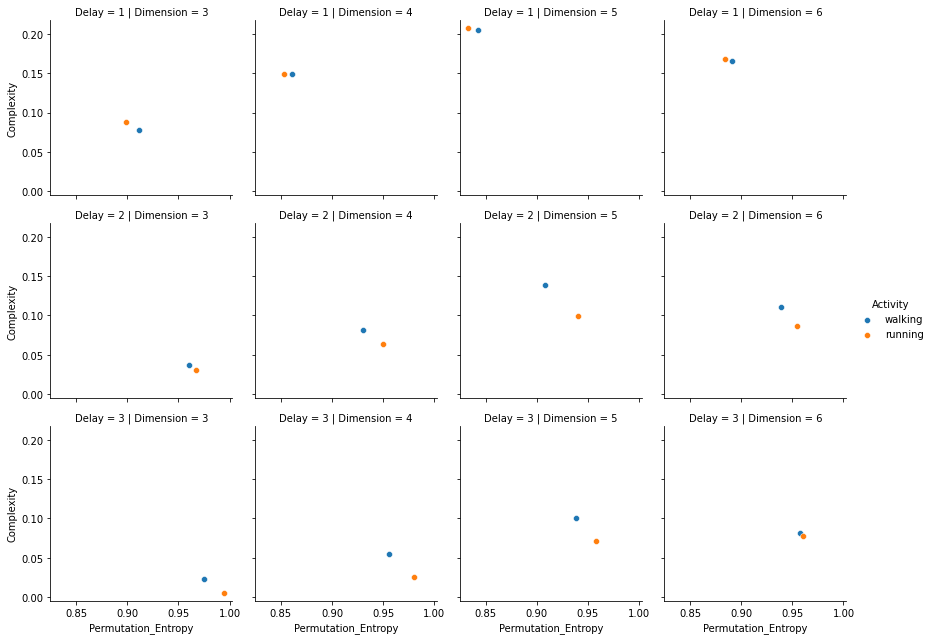

In [15]:
import seaborn as sns


# Create a FacetGrid with 'Delay' and 'Dimension'
g = sns.FacetGrid(activity_data_walk_run, 
                  col="Dimension", 
                  row="Delay",
                  hue="Activity")
                  #height=2,
                  #aspect=1, 
                  #palette='coolwarm')

g.map_dataframe(sns.scatterplot, x = "Permutation_Entropy", y = "Complexity")

g.add_legend()


To analyze the best separation for the walking and running activities in this scatter plot, we can look at each subplot to identify where the points for these activities are farthest apart in terms of Permutation Entropy and Complexity values. 
##### Observation:  
The subplot with Dimension =4 and Delay= 3  shows the clear separation for the activities walking and running.

##### Optimum dimension :(Dimension=5 and Delay=2)
But the optimum dimensions for separation of the activities walking and running is seen in the subplot with Dimension=5 and Delay=2.

In this subplot, the points forwalking and running are well-separated in both the Permutation Entropy and Complexity axes, making these settings ideal for distinguishing between the two activities. This configurations is likely the most useful for classification or analysis involving these two activities.

## 
Using scatter plots, identify the optimum dimension, delay and signal length that provide the best separation between climbing up and climbing down for the filtered data from task 3.

##### Filtering data for activities: climbingup and climbing down for subject "s5" from s5_filtered_data and storing result in "activity_data_climb".

In [16]:
activity_data_climb = s5_filtered_data[s5_filtered_data['Activity'].isin(['climbingdown','climbingup'])]

print("Total rows in activity_data_climb:",len(activity_data_climb))

activity_data_climb


Total rows in activity_data_climb: 24


,Subject,Activity,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation_Entropy,Complexity
0,s5,climbingup,attr_x,1024,3,1,0.910388,0.077889
1,s5,climbingup,attr_x,1024,3,2,0.967399,0.029952
2,s5,climbingup,attr_x,1024,3,3,0.975406,0.022696
3,s5,climbingup,attr_x,1024,4,1,0.870686,0.134494
4,s5,climbingup,attr_x,1024,4,2,0.941821,0.068982
5,s5,climbingup,attr_x,1024,4,3,0.957699,0.051624
6,s5,climbingup,attr_x,1024,5,1,0.849132,0.191200
7,s5,climbingup,attr_x,1024,5,2,0.920750,0.122935
8,s5,climbingup,attr_x,1024,5,3,0.942968,0.090879
9,s5,climbingup,attr_x,1024,6,1,0.885896,0.167449


#### Scatter plot for climbingup and climbingdown activities of subject s5

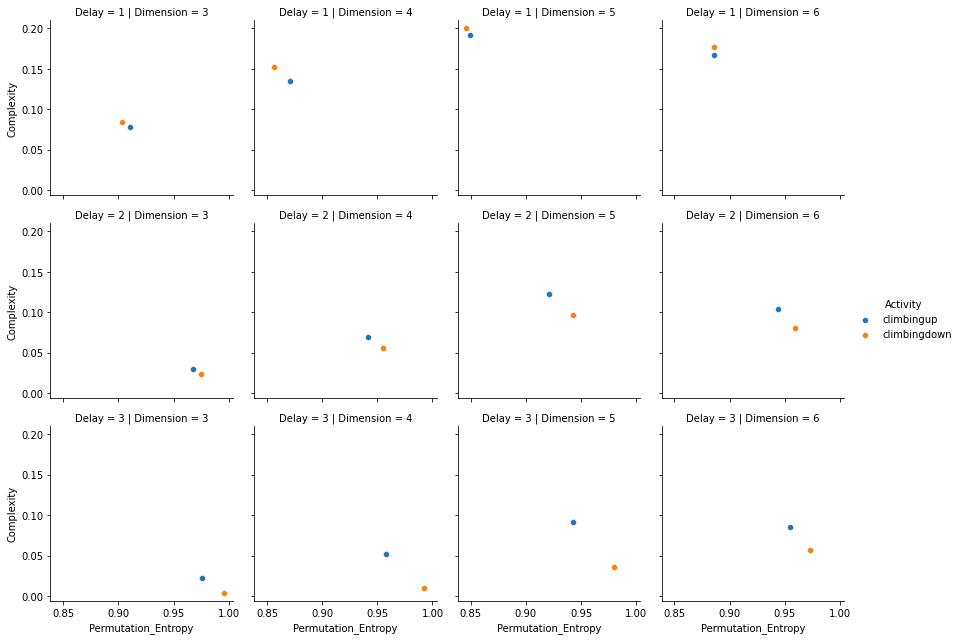

In [17]:
import seaborn as sns


# Create a FacetGrid with 'Delay' and 'Dimension'
g = sns.FacetGrid(activity_data_climb, 
                  col="Dimension", 
                  row="Delay",
                  hue="Activity")
                  #height=2,
                  #aspect=1, 
                  #palette='coolwarm')

g.map_dataframe(sns.scatterplot, x = "Permutation_Entropy", y = "Complexity")

g.add_legend()


To analyze the best separation for the climbingup and climbingdown activities in this scatter plot, we can look at each subplot to identify where the points for these activities are farthest apart in terms of Permutation Entropy and Complexity values. 
##### Observation: 
The subplot with Dimension =4 and Delay= 3  shows the clear separation for the activities climbingup and climbingdown.
##### Optimum dimension :(Dimension =5 and Delay= 3)
But the optimum dimensions for separation of the activities climbingup and climbingdown is seen in the subplot with Dimension =5 and Delay= 3.
In this subplot, the points for climbingup and climbingdown are well-separated in both the Permutation Entropy and Complexity axes, making these settings ideal for distinguishing between the two activities. This configurations is likely the most useful for classification or analysis involving these two activities.